# Import Librarie

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import math

# EDA

In [12]:
def prediction_plot(test, predicted):
    plt.plot(test, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Prediction vs Actual')
    plt.show()
    
def rmse_eval(test, predicted):
    mse = np.mean((predicted - test)**2)
    rmse = np.sqrt(mse)
    return rmse

In [13]:
dataset = pd.read_csv('MMM_2006-01-01_to_2018-01-01.csv')
dataset

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
1,2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2,2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
3,2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
4,2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM
...,...,...,...,...,...,...,...
3015,2017-12-22,235.36,236.08,234.28,234.73,1280557,MMM
3016,2017-12-26,235.08,236.28,235.03,235.45,789090,MMM
3017,2017-12-27,235.52,236.54,234.84,236.20,970508,MMM
3018,2017-12-28,236.94,237.08,235.28,235.72,1189738,MMM


In [14]:
dataset = dataset.drop('Name', axis=1)

In [15]:
dataset.isnull().sum()

Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
dtype: int64

In [16]:
dataset.dropna(inplace = True, axis = 0)

In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3019 entries, 0 to 3019
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


In [18]:
dataset.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,111.776588,112.586237,110.986366,111.832262,3.342832e+06
std,44.430095,44.544845,44.348715,44.471353,1.901496e+06
min,41.310000,42.450000,40.870000,41.830000,8.708300e+04
25%,79.235000,79.810000,78.335000,79.115000,2.100758e+06
50%,89.670000,90.330000,88.860000,89.740000,2.857305e+06
75%,145.845000,147.525000,145.250000,146.245000,3.982865e+06
max,243.190000,244.230000,239.150000,243.140000,2.436050e+07


In [19]:
dataset = dataset[['Date', 'Close']]

In [20]:
# Change colums Date type from objact to date
 
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

dataset['Date'] = dataset['Date'].apply(str_to_datetime)
dataset['Date']

0      2006-01-03
1      2006-01-04
2      2006-01-05
3      2006-01-06
4      2006-01-09
          ...    
3015   2017-12-22
3016   2017-12-26
3017   2017-12-27
3018   2017-12-28
3019   2017-12-29
Name: Date, Length: 3019, dtype: datetime64[ns]

In [21]:
dataset.index = dataset.pop('Date')
dataset

,Close
Date,
2006-01-03,79.11
2006-01-04,78.71
2006-01-05,77.99
2006-01-06,78.63
2006-01-09,79.02
...,...
2017-12-22,234.73
2017-12-26,235.45
2017-12-27,236.20


* Berdasarkan pengecekan data yang dilakukan awalnya data tanggal bertipe objek, olej karena itu perlu mengubahnya ke datetime.
* dataframe berisi data harga saham selama 12 tahun dari 2006 sampai 2017.
* terdapat variabel yang tidak diperlukan yaitu tabel nama.
* variabel yang menjadi target adalah close atau harga saham saat penutupan dihari tertentu.

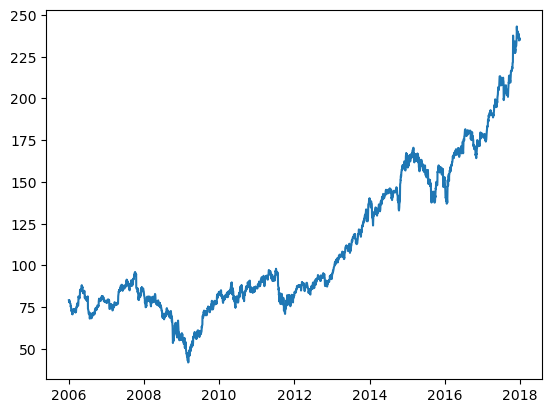

In [22]:
plt.plot(dataset.index, dataset['Close'])

In [23]:
# Normalisasi data ke dalam rentang 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(dataset)

In [24]:
# Membagi data menjadi data tain dan data test
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

In [25]:
# Membuat fungsi untuk mengonversi data ke dalam format time series
def create_time_series(data, lookback):
    X, Y = [], []
    for i in range(len(data)-lookback-1):
        X.append(data[i:(i+lookback), 0])
        Y.append(data[i+lookback, 0])
    return np.array(X), np.array(Y)

In [26]:
# Menentukan jumlah time steps (lookback) dan mengonversi data ke dalam format time series
lookback = 20
train_X, train_Y = create_time_series(train_data, lookback)
test_X, test_Y = create_time_series(test_data, lookback)

In [27]:
# Reshape input menjadi bentuk yang dapat diterima oleh LSTM layer
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

## Modelling

In [28]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [31]:
# Melatih model
model.fit(train_X, train_Y, epochs=50, batch_size=32)

Epoch 1/50
75/75 [==============================] - 10s 27ms/step - loss: 0.0080
Epoch 2/50
75/75 [==============================] - 2s 27ms/step - loss: 1.9152e-04
Epoch 3/50
75/75 [==============================] - 2s 27ms/step - loss: 1.8112e-04
Epoch 4/50
75/75 [==============================] - 2s 28ms/step - loss: 1.7384e-04
Epoch 5/50
75/75 [==============================] - 2s 32ms/step - loss: 1.6813e-04
Epoch 6/50
75/75 [==============================] - 2s 31ms/step - loss: 1.6311e-04
Epoch 7/50
75/75 [==============================] - 2s 31ms/step - loss: 1.5847e-04
Epoch 8/50
75/75 [==============================] - 3s 34ms/step - loss: 1.5281e-04
Epoch 9/50
75/75 [==============================] - 2s 29ms/step - loss: 1.5189e-04
Epoch 10/50
75/75 [==============================] - 2s 27ms/step - loss: 1.5052e-04
Epoch 11/50
75/75 [==============================] - 2s 29ms/step - loss: 1.4595e-04
Epoch 12/50
75/75 [==============================] - 2s 33ms/step - loss: 1.6

In [32]:
# Memprediksi harga saham menggunakan model yang sudah dilatih
predicted = model.predict(test_X)
predicted = scaler.inverse_transform(predicted)

19/19 [==============================] - 0s 10ms/step


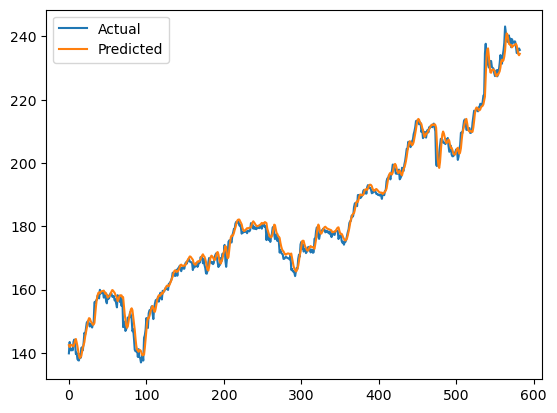

In [33]:
# Menampilkan plot hasil prediksi
plt.plot(scaler.inverse_transform(test_Y.reshape(-1, 1)), label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()

In [34]:
trainScore = model.evaluate(train_X, train_Y, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(test_X, test_Y, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00006121 MSE (0.00782394 RMSE)
Test Score: 0.00011201 MSE (0.01058343 RMSE)


In [35]:
evaluation_score = model.evaluate(test_X, test_Y)
print('Evaluation Score:', evaluation_score)

19/19 [==============================] - 0s 13ms/step - loss: 1.1201e-04
Evaluation Score: 0.00011200905282748863


* Berdasarkan visualisasi yang telah dilakukan diketahui bahwa harga saha mengalami peningkatan secara keseluruhan dari tahun 2006 sampai 2017
* Pada tahun 2008 sampai sekitar tahun 2009 harga saham mengalami penurunan karen pada masa tersebut terjadinya krisis ekonomi dunia pada tahun 2008.
* Pada case ini menggunakan model LSTM(ong Short-Term Memory).
* Model di evaluasi dengan menggunakan RMSE evaluation dan prediction plot.
* Dari hasil Evaluasi dapat dilihat bahwan Nilai RMSE yang diperoleh kecil baik pada dataset train dan dataset test.
* Nilai Evaluation Score pada prediction plot juga diperoleh kecil hal ini manandakan bahwa model memiliki kinerja yang baik karena tinggkat kesalahannya kecil.